## Adaptive Robot goes through maze

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import matplotlib

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import os
from datetime import datetime
import func as func
import math
pi = math.pi

In [2]:
def write_par():
    '''write parameters in the path named Datapath '''
    f = open(Datapath + "/parameters_run.txt", "w+")
    f.write('intrisic velocity of each active particle: \r\n' + str(c_g) + '\n')

    f.write('time step dt : \r\n' + str(dt) + '\n')
    f.write('Max iteration time : \r\n' + str(tau) + '\n')

    f.write('Number of the active particle :' + '\r\n' + str(N_p) + '\n')
    f.write('Number of the Wall  :' + '\r\n' + str(N_w) + '\n')

    f.write('Diameter of the active particle :' + '\r\n' + str(D) + '\n')
    f.write('Diameter of the wall : \r\n' + str((DW-R)*2) + '\n')
    f.write('noise level : \r\n' + str(eta) + '\n')

    f.write('LJ strength : \r\n' + str(c_LJ) + '\n')
    f.write('MAX cutoff dis for the LJ between particle and wall : \r\n' + str(DW+FWR) + '\n')
    f.write('MIN cutoff dis for the LJ between particle and wall : \r\n' + str(0.8*DW) + '\n')

    f.write('Kspring : \r\n' + str(kspring) + '\n')
    f.write('cutoff dis from equilibrum dis for the spring between particle and particle : \r\n' + str(FR) + '\n')
    
    if c_active ==0:
        f.write('NOT active''\n')
    else:
        f.write('active''\n')
        f.write('alpha(las in the code), continuous changing for theta:\r\n' + str(las)+ '\n')
        if not_adap == False:    
            f.write('parameters discribing the adaptive force(A*(alp * ad_f / (1 + alp * ad_f))), A and alp:\r\n' + str(c_active) +',' + str(alp) + '\n')
    f.close()


In [3]:
def PointsInCircum(a,b,n=100):
    return np.array([[math.cos(2*pi/n*x)*a,math.sin(2*pi/n*x)*b] for x in range(0,n+1)])

def plot_circles(fig, ax, x, y, r, c='r', cmap=matplotlib.cm.rainbow, ticks=[0, 1]):
    patches = []
    for x1, y1 in zip(x, y):
        circle = plt.Circle((x1, y1), r)
        patches.append(circle)

    if isinstance(c, str):
        p = PatchCollection(patches, facecolor="None", edgecolor=c, alpha=1, linewidths=2)
        ax.add_collection(p)
        return ax

    else:
        p = PatchCollection(patches, cmap=cmap, alpha=0.8)
        p.set_array(np.array(c))

    ax.add_collection(p)

    # cbar = fig.colorbar(p, ax=ax,ticks=ticks)
    p.set_clim(min(ticks), max(ticks))
    return fig,p

def plot_active_force(c_active, alp, c_g):
    plt.plot(np.arange(0,10,0.1),c_active/c_g * (alp * np.arange(0,10,0.1) / (1 + alp * np.arange(0,10,0.1))))
    plt.ylabel('active velocity ($1/c_g$)', fontsize = 20)
    plt.xlabel('total velocity from last time v(t-1)', fontsize = 20)
    plt.show()

    plt.close()

def visualization(not_adap):
    fig = plt.figure(figsize = (8,8))

    ax = fig.add_subplot(111,aspect='equal') 
    plt.title('time at %0.2f'%time+' with active = %0.1f c_g'%(c_active/c_g) ,fontsize=15)
    
    plot_circles(fig,ax,rp[:,0],rp[:,1],R, actf)
    
    fig,p= plot_circles(fig,ax,rw[:,0],rw[:,1],RW,la.norm(FWfeel, axis = 1), cmap = matplotlib.cm.coolwarm, ticks=[0, 100])
    cbar = fig.colorbar(p, ax=ax,orientation="horizontal",fraction=0.07,anchor=(1.0,0.0))
    

    plt.xlabel('force on wall = %d'%tot_Fwall,fontsize=15)
    ax.quiver(rp[:,0],rp[:,1], force[:,0], force[:,1], linewidth = 25, headwidth=10, units = 'xy', scale = 10)
    # ax.quiver(rp[:,0],rp[:,1], c_active*ad_f*n_vec_theta[:,0], 
    #           c_active*ad_f*n_vec_theta[:,1], linewidth = 15, headwidth=10, color= 'b')
    ax.quiver(rw[:,0], rw[:,1], FWfeel[:,0], FWfeel[:,1],
              linewidth = 25, headwidth=10, units = 'xy', scale = 10, color = 'r')

    plt.xlim(np.amin(rw[:,0]-2*RW),np.amax(rw[:,0]+2*RW))
    plt.ylim(np.amin(rw[:,1]-2*RW),np.amax(rw[:,1]+4*RW))
    # plt.xticks([])
    plt.yticks([])

    if not_adap==False and c_active !=0:
        a = plt.axes([0.8, 0.3, .2, .2])
        xx = np.arange(0,20,0.5)
        plt.plot(xx,(alp * xx / (1 + alp * xx)))

        plt.scatter(ad_f, actf, c=actf, cmap = matplotlib.cm.rainbow,
                    vmin=0, vmax=1, alpha = 1.)
        plt.colorbar()
        plt.ylabel('active velocity ',fontsize = 15)
        plt.xlabel('$\|f(t-1)*\hat{n}\|$',fontsize = 15)
        plt.yticks([])

    if len(force[:,0]) ==1:
        a = plt.axes([0.6, 0.6, .2, .2])
        plt.annotate("",xy=(pas_force[:,0], pas_force[:,1]),xytext=(0,0),
                 arrowprops=dict(facecolor='b', shrink=0.05),alpha = 0.5)
 
        plt.annotate("",xy=(c_active*actf*n_vec_theta[:,0], c_active*actf*n_vec_theta[:,1]),xytext=(0,0),
                             arrowprops=dict(facecolor='r', shrink=0.05))
        
        if c_active !=0:
            plt.ylim(-c_g/2.-c_active,c_g/2.+c_active)
            plt.xlim(-c_g/2.-c_active,c_g/2.+c_active)
        else:
            plt.ylim(-2*c_g,2*c_g)
            plt.xlim(-2*c_g,2*c_g)
        plt.xticks([])
        plt.yticks([])
        plt.title('passive(b) vs active(r)',fontsize = 15)

    return fig

    

# set up parameters

In [4]:
N_s = 0 #skin active connected by spring
tot_Fwall = 0 # total force acting on wall

dt = 0.005

tau = 40
eta = 0.1 #noise 
sqdt = np.sqrt(dt) #noise 

R = 0.5 # radius of beads
D = 2 * R # diameter
RW = 6 * R # radius of Wall
DW = RW + R # distance between center of bead and center of the Wall


FR = R# cutoff range of force between beads(repulsion if surface distance < R)
FWR = 2 * R# cutoff range of force between bead and wall (repulsion if surface distance < 2*R)
c_LJ = 1.

c_cutoff = c_LJ *(12*(DW/(0.8*DW)) ** (13))
print(c_cutoff)
alp = 0.5 #[0,5]

not_adap = False
c_active = 2.
c_g = 2.

las = 0.1 #[0,1] when las=1 the change of theta is instantaneous 
kspring = 5*(c_g+c_active)
kskin = 10*(c_g+c_active)



218.27872842550227


In [5]:
def initialize():
    
    #initialize positions of everyone
    rb, rs, s_id = make_s_b()
    
    N_b = len(rb)
    plt.scatter(rb[:,0], rb[:,1])
    
    rw = func.make_hex(3,2)
    rw[:,0] = rw[:,0].copy()*(max(rb[:,0])*1.5+2.5*RW)-DW
    rw[:,1] = rw[:,1].copy()*(max(rb[:,1])*1.5+2.5*RW)
    rw[:,1] += -max(rw[:,1].copy())-DW*np.max(rb[:,1])

    N_w = len(rw)  

    thetas_vec = np.zeros((N_b,2))
    thetas_vec[s_id,1] = np.tile([-1], len(s_id))

    vec_n = np.zeros(2)
    #print(vec_n[1])
    ad_f = np.zeros(N_b)
    ad_f[s_id] = 1
    if not_adap == True:
        actf = ad_f 
    else:
        actf =(alp * ad_f / (1 + alp * ad_f)) #+c_active# active driving force initially 0
       
    return rb, s_id, rw, thetas_vec, vec_n, ad_f, actf, N_b, N_w

def make_s_b():
    body = func.make_hex(2,1)
    body[:,1] = body[:,1]-np.mean(body[:,1])
    body = np.round(body,3)
    print(len(body))
    ra = max(body[:,0])+2*R
    rb = max(body[:,1])+2*R
    big_r = max(ra,rb)
    cir = 2*np.pi*big_r
    print(cir)
    skin = PointsInCircum(ra, rb, n=int(cir))[:int(cir)]#max(int(cir),len(body)))
    plt.scatter(skin[:,0], skin[:,1])
    plt.scatter(body[:,0],body[:,1])
    tot = np.concatenate((body,skin), axis = 0)
    s_id = np.arange(len(body), len(body)+len(skin))

    return tot, skin, s_id


not instantanous
7
12.566370614359172


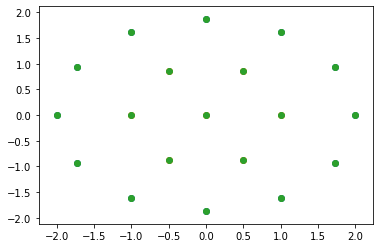

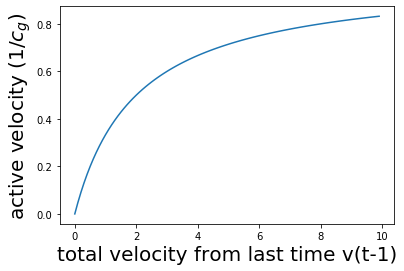

In [7]:
AVEFORCES = []
TIMES = []

if not_adap:
    print('its not adaptive')
if las != 1:
    print('not instantanous')

rp, s_id, rw, n_vec_theta, vec_n, ad_f, actf, N_p, N_w = initialize()
plt.show()
vec_theta = np.zeros(np.shape(n_vec_theta))

if c_active != 0 and not_adap == False:
    plot_active_force(c_active, alp, c_g)
tot_Fwall = 0
plt.show()



In [8]:
Timenow = str(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
Datapath = '/Users/jiayiwu/projects/softrobot/experiment/' + Timenow
if not os.path.exists(Datapath): os.mkdir(Datapath)
print(Datapath)
write_par()

/Users/jiayiwu/projects/softrobot/experiment/2019_09_12_15_16_37


In [9]:
for time in np.arange(0, tau, dt):

    # initializefoce by the thermal noise force
    force = eta * (np.random.rand(N_p, 2) - 0.5) / sqdt
    FWfeel = np.zeros((N_w, 2))

    # loop around all movable particles:    
    # calculate repulsive force 
    for p_id in range(0, N_p):
        # print(rp)
        xy = rp[p_id, :]
        # %%%force with wall 
        for i in range(0, N_w):
            vec_n = -rw[i, :] + xy
            dis = la.norm(vec_n)  # calculate distance
            
            if dis - DW < FR:  # only count when within range

                strength = np.min([c_cutoff, c_LJ * (12 * (DW / dis) ** (13))])

                force[p_id, :] += strength * vec_n / dis
                FWfeel[i, :] += strength * vec_n / dis

        tot_Fwall += sum(la.norm(FWfeel, axis=1))
        # %%%force with skin+skin particle
        if p_id in s_id:
            for i in s_id:  # all movable particles

                if i != p_id:  # but can't interact with self

                    vec_n = -rp[i, :] + xy
                    dis = la.norm(vec_n)  # calculate distance
                    if dis - D < FR/2.:

                        # print(dis, x, y, rp[i,0], rp[i,1])
                        strength = np.round(-kskin * (dis - D),
                                            2)  # + np.min([100,c_LJ * (12*(D/dis) ** (13) - 12 * (D/dis) ** (7))])                  
                        # strength = c_r * (1-dis+D)^n_rep;
                        force[p_id, :] = force[p_id, :] + strength * vec_n / dis

        
        # %%%force with other body+skin particle
        for i in range(N_p):  # all movable particles
            
            if i != p_id:  # but can't interact with self
                
                vec_n = -rp[i, :] + xy
                dis = la.norm(vec_n)  # calculate distance
                if dis - D < FR/2.:
                
                    # print(dis, x, y, rp[i,0], rp[i,1])
                    strength = np.round(-kspring * (dis - D),
                                      2)  # + np.min([100,c_LJ * (12*(D/dis) ** (13) - 12 * (D/dis) ** (7))])                  
                    # strength = c_r * (1-dis+D)^n_rep;
                    force[p_id, :] = force[p_id, :] + strength * vec_n / dis


    force[:, 1] += -c_g
    
    pas_force = force.copy()
   
    force[:, 0][s_id] += c_active * (actf * n_vec_theta[:, 0])[s_id]
    force[:, 1][s_id] += c_active * (actf * n_vec_theta[:, 1])[s_id] 
    
    rp = rp + dt * force

    # datasaving and plotting
    if (time / dt) % 20 == 0:

        savedir = Datapath + '/rp_force_data/'

        if not os.path.exists(savedir): os.mkdir(savedir)
        np.save(savedir + '/%04d' % (time / dt), np.array([rp, force]))
        fig = visualization(not_adap)

        plotdir = Datapath + '/images/'
        if not os.path.exists(plotdir): os.mkdir(plotdir)
        
        plt.savefig(plotdir + '/%04d.png' % (time / dt), bbox_inches="tight")
#         plt.show()
        plt.close()
#         sys.exit()

    # update active forces if c_active != 0
    if c_active != 0:
        vec_theta[s_id, 0] = c_active * actf[s_id] * n_vec_theta[s_id, 0] * (1 - las) + force[s_id, 0] * las
        vec_theta[s_id, 1] = c_active * actf[s_id] * n_vec_theta[s_id, 1] * (1 - las) + force[s_id, 1] * las
        n_vec_theta[s_id, 0] = vec_theta[s_id, 0] / la.norm(vec_theta, axis=1)[s_id]
        n_vec_theta[s_id, 1] = vec_theta[s_id, 1] / la.norm(vec_theta, axis=1)[s_id]

                      
        if not not_adap:
            ad_f[s_id] = abs(np.sum(force * n_vec_theta, axis=1))[s_id]
            actf = (alp * ad_f / (1 + alp * ad_f))

#     check if it goes through the maze
    if max(rp[:, 1]) < min(rw[:,1])-5:

        print('all particles go through at time', time)
        print('with the total force exerted on wall', tot_Fwall)
        print('c_g is', c_g)

        AVEFORCES.append(tot_Fwall / time)
        TIMES.append(time)
        print(TIMES)
        func.make_movie(plotdir + '/', plotdir[:-8])

        break


all particles go through at time 37.255
with the total force exerted on wall 1066372.8082156845
c_g is 2.0
[37.255]
/Users/jiayiwu/projects/softrobot/experiment/2019_09_12_15_16_37/images//
/Users/jiayiwu/projects/softrobot/experiment/2019_09_12_15_16_37
